In [ ]:
!pip install albumentations --quiet


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ACV Project.zip to ACV Project.zip


In [ ]:
!unzip 'ACV Project.zip'

Archive:  ACV Project.zip
  inflating: DRIVE/test/images/01_test.tif  
  inflating: DRIVE/test/images/02_test.tif  
  inflating: DRIVE/test/images/03_test.tif  
  inflating: DRIVE/test/images/04_test.tif  
  inflating: DRIVE/test/images/05_test.tif  
  inflating: DRIVE/test/images/06_test.tif  
  inflating: DRIVE/test/images/07_test.tif  
  inflating: DRIVE/test/images/08_test.tif  
  inflating: DRIVE/test/images/09_test.tif  
  inflating: DRIVE/test/images/10_test.tif  
  inflating: DRIVE/test/images/11_test.tif  
  inflating: DRIVE/test/images/12_test.tif  
  inflating: DRIVE/test/images/13_test.tif  
  inflating: DRIVE/test/images/14_test.tif  
  inflating: DRIVE/test/images/15_test.tif  
  inflating: DRIVE/test/images/16_test.tif  
  inflating: DRIVE/test/images/17_test.tif  
  inflating: DRIVE/test/images/18_test.tif  
  inflating: DRIVE/test/images/19_test.tif  
  inflating: DRIVE/test/images/20_test.tif  
  inflating: DRIVE/test/mask/01_test_mask.gif  
  inflating: DRIVE/test/ma

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [ ]:
class VesselDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.resize(image, (256,256))
        image = image / 255.0

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (256,256))
        mask = mask / 255.0

        image = torch.tensor(image).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return image, mask


In [ ]:
dataset = VesselDataset(
    "DRIVE/training/images",
    "DRIVE/training/mask"
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.d1 = DoubleConv(3,64)
        self.d2 = DoubleConv(64,128)
        self.d3 = DoubleConv(128,256)

        self.pool = nn.MaxPool2d(2)

        self.u1 = DoubleConv(256+128,128)
        self.u2 = DoubleConv(128+64,64)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear")
        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        c1 = self.d1(x)
        p1 = self.pool(c1)

        c2 = self.d2(p1)
        p2 = self.pool(c2)

        c3 = self.d3(p2)

        u1 = self.up(c3)
        u1 = torch.cat([u1,c2],1)
        c4 = self.u1(u1)

        u2 = self.up(c4)
        u2 = torch.cat([u2,c1],1)
        c5 = self.u2(u2)

        return torch.sigmoid(self.out(c5))


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()


In [ ]:
class VesselDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return min(len(self.images), len(self.masks))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)

        # safety check
        if image is None or mask is None:
            print("Error loading:", img_path, mask_path)
            return self.__getitem__((idx+1) % len(self))

        image = cv2.resize(image, (256,256))
        mask = cv2.resize(mask, (256,256))

        image = image / 255.0
        mask = mask / 255.0

        image = torch.tensor(image).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return image, mask


In [ ]:
import re
import os
import cv2
import torch
from torch.utils.data import Dataset

class VesselDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.images = sorted(os.listdir(img_dir))
        self.masks = sorted(os.listdir(mask_dir))

        # map mask numbers
        self.mask_map = {}
        for m in self.masks:
            num = re.findall(r'\d+', m)[0]
            self.mask_map[num] = m

        self.pairs = []
        for img in self.images:
            num = re.findall(r'\d+', img)[0]
            if num in self.mask_map:
                self.pairs.append((img, self.mask_map[num]))

        print("Total matched pairs:", len(self.pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)

        image = cv2.resize(image, (256,256))
        mask = cv2.resize(mask, (256,256))

        image = image / 255.0
        mask = mask / 255.0

        image = torch.tensor(image).permute(2,0,1).float()
        mask = torch.tensor(mask).unsqueeze(0).float()

        return image, mask


In [ ]:
import os

def find_folders(root="."):
    img_dir, mask_dir = None, None

    for path, dirs, files in os.walk(root):
        if len(files) > 0:
            lname = path.lower()

            if "image" in lname:
                img_dir = path

            if "mask" in lname or "manual" in lname:
                mask_dir = path

    return img_dir, mask_dir

img_dir, mask_dir = find_folders(".")

print("Images folder:", img_dir)
print("Masks folder:", mask_dir)


Images folder: ./DRIVE/training/images
Masks folder: ./DRIVE/training/mask


In [ ]:
dataset = VesselDataset(img_dir, mask_dir)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

print("Dataset size:", len(dataset))


Total matched pairs: 20
Dataset size: 20


In [ ]:
img, mask = dataset[0]


In [ ]:
epochs = 15

for epoch in range(epochs):
    total_loss = 0

    for img, mask in loader:
        img, mask = img.to(device), mask.to(device)

        pred = model(img)
        loss = criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 2.9940
Epoch 2: Loss = 1.5843
Epoch 3: Loss = 0.8038
Epoch 4: Loss = 0.3045
Epoch 5: Loss = 0.1223
Epoch 6: Loss = 0.0829
Epoch 7: Loss = 0.0713
Epoch 8: Loss = 0.0577
Epoch 9: Loss = 0.0571
Epoch 10: Loss = 0.0467
Epoch 11: Loss = 0.0468
Epoch 12: Loss = 0.0434
Epoch 13: Loss = 0.0411
Epoch 14: Loss = 0.0415
Epoch 15: Loss = 0.0392


In [ ]:
torch.save(model.state_dict(), "vessel_model.pth")


In [ ]:
from google.colab import files
files.download("vessel_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.eval()

img, mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0,0].cpu()

pred_mask = (pred > 0.5).float()


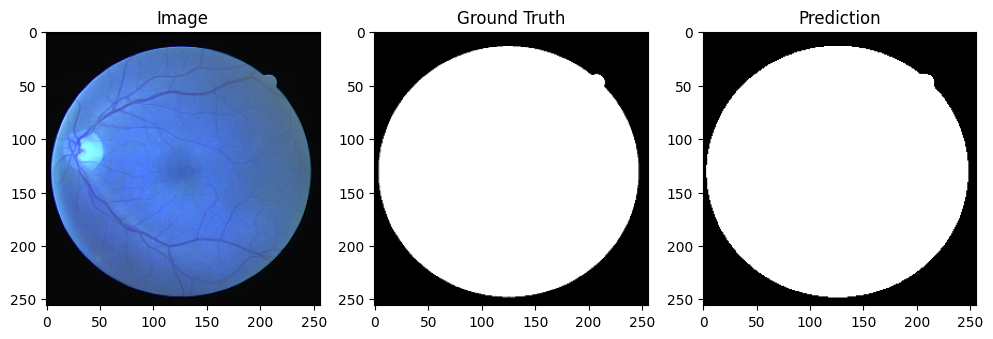

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Prediction")

plt.show()


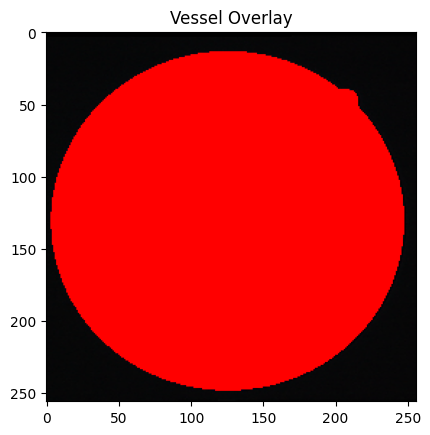

In [ ]:
overlay = img.permute(1,2,0).numpy().copy()
overlay[pred_mask.numpy() > 0] = [1,0,0]

plt.imshow(overlay)
plt.title("Vessel Overlay")
plt.show()


In [ ]:
def dice_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()

    return (2. * intersection + 1e-8) / \
           (pred.sum() + target.sum() + 1e-8)

score = dice_score(pred_mask, mask)
print("Dice Score:", score.item())


Dice Score: 0.9952797293663025


In [ ]:
import torch

def precision_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    TP = (pred * target).sum()
    FP = (pred * (1 - target)).sum()

    precision = TP / (TP + FP + 1e-8)
    return precision.item()


def recall_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    TP = (pred * target).sum()
    FN = ((1 - pred) * target).sum()

    recall = TP / (TP + FN + 1e-8)
    return recall.item()


def iou_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = intersection / (union + 1e-8)
    return iou.item()


In [ ]:
model.eval()

img, mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0,0].cpu()

pred_mask = (pred > 0.5).float()


In [ ]:
precision = precision_score(pred_mask, mask)
recall = recall_score(pred_mask, mask)
iou = iou_score(pred_mask, mask)

print("Precision:", precision)
print("Recall:", recall)
print("IoU:", iou)


Precision: 0.9906074404716492
Recall: 0.9999964237213135
IoU: 0.9906038045883179


In [ ]:
p_total, r_total, iou_total = 0,0,0

for img, mask in dataset:
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))[0,0].cpu()

    pred_mask = (pred > 0.5).float()

    p_total += precision_score(pred_mask, mask)
    r_total += recall_score(pred_mask, mask)
    iou_total += iou_score(pred_mask, mask)

n = len(dataset)

print("Avg Precision:", p_total/n)
print("Avg Recall:", r_total/n)
print("Avg IoU:", iou_total/n)


Avg Precision: 0.9978171855211257
Avg Recall: 0.997722789645195
Avg IoU: 0.9955433756113052


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
        )

        self.skip = nn.Conv2d(in_c, out_c, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv(x) + self.skip(x))


In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, Fg, Fl, Fint):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(Fg, Fint, 1),
            nn.BatchNorm2d(Fint)
        )

        self.Wx = nn.Sequential(
            nn.Conv2d(Fl, Fint, 1),
            nn.BatchNorm2d(Fint)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(Fint, 1, 1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU()

    def forward(self, g, x):
        psi = self.relu(self.Wg(g) + self.Wx(x))
        psi = self.psi(psi)
        return x * psi


In [ ]:
class HybridUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(2)

        # Encoder
        self.e1 = ResidualBlock(3,64)
        self.e2 = ResidualBlock(64,128)
        self.e3 = ResidualBlock(128,256)

        # Bottleneck
        self.b = ResidualBlock(256,512)

        # Attention blocks
        self.att2 = AttentionBlock(256,256,128)
        self.att1 = AttentionBlock(128,128,64)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear")

        # Decoder
        self.d2 = ResidualBlock(512+256,256)
        self.d1 = ResidualBlock(256+128,128)

        self.final = nn.Conv2d(128,1,1)

    def forward(self,x):
        c1 = self.e1(x)
        p1 = self.pool(c1)

        c2 = self.e2(p1)
        p2 = self.pool(c2)

        c3 = self.e3(p2)
        p3 = self.pool(c3)

        b = self.b(p3)

        u2 = self.up(b)
        a2 = self.att2(u2, c3)
        u2 = torch.cat([u2,a2],1)
        c4 = self.d2(u2)

        u1 = self.up(c4)
        a1 = self.att1(u1, c2)
        u1 = torch.cat([u1,a1],1)
        c5 = self.d1(u1)

        return torch.sigmoid(self.final(c5))


In [ ]:
model = HybridUNet().to(device)


In [ ]:
import torch
import torch.nn as nn

# ---------- Residual Block ----------
class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
        )

        self.skip = nn.Conv2d(in_c, out_c, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.conv(x) + self.skip(x))


# ---------- Hybrid UNet ----------
class HybridUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear")

        # Encoder
        self.e1 = ResidualBlock(3,64)
        self.e2 = ResidualBlock(64,128)
        self.e3 = ResidualBlock(128,256)

        # Bottleneck
        self.b = ResidualBlock(256,512)

        # Decoder
        self.d3 = ResidualBlock(512+256,256)
        self.d2 = ResidualBlock(256+128,128)
        self.d1 = ResidualBlock(128+64,64)

        self.final = nn.Conv2d(64,1,1)

    def forward(self,x):
        # Encoder
        c1 = self.e1(x)
        p1 = self.pool(c1)

        c2 = self.e2(p1)
        p2 = self.pool(c2)

        c3 = self.e3(p2)
        p3 = self.pool(c3)

        # Bottleneck
        b = self.b(p3)

        # Decoder
        u3 = self.up(b)
        u3 = torch.cat([u3,c3],1)
        c4 = self.d3(u3)

        u2 = self.up(c4)
        u2 = torch.cat([u2,c2],1)
        c5 = self.d2(u2)

        u1 = self.up(c5)
        u1 = torch.cat([u1,c1],1)
        c6 = self.d1(u1)

        return torch.sigmoid(self.final(c6))


In [ ]:
def precision_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    TP = (pred * target).sum()
    FP = (pred * (1 - target)).sum()

    return (TP / (TP + FP + 1e-8)).item()


def recall_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    TP = (pred * target).sum()
    FN = ((1 - pred) * target).sum()

    return (TP / (TP + FN + 1e-8)).item()


def iou_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    return (intersection / (union + 1e-8)).item()


def dice_score(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    intersection = (pred * target).sum()

    return ((2 * intersection + 1e-8) /
            (pred.sum() + target.sum() + 1e-8)).item()


In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class HybridUNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pool = nn.MaxPool2d(2)

        # Encoder
        self.enc1 = DoubleConv(3, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):

        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.final(d1))


In [ ]:
model = HybridUNet().to(device)


In [ ]:
model.eval()

p_total = 0
r_total = 0
i_total = 0
d_total = 0

with torch.no_grad():
    for img, mask in loader:   # use loader, not dataset
        img = img.to(device)
        mask = mask.to(device)

        pred = model(img)
        pred_mask = (pred > 0.5).float()

        for i in range(img.size(0)):
            p_total += precision_score(pred_mask[i], mask[i])
            r_total += recall_score(pred_mask[i], mask[i])
            i_total += iou_score(pred_mask[i], mask[i])
            d_total += dice_score(pred_mask[i], mask[i])

n = len(dataset)

print("Precision:", p_total/n)
print("Recall:", r_total/n)
print("IoU:", i_total/n)
print("Dice:", d_total/n)


Precision: 0.0
Recall: 0.0
IoU: 0.0
Dice: 2.2174309643237938e-13


In [ ]:
torch.save(model.state_dict(), "hybrid_unet.pth")


In [ ]:
from google.colab import files
files.download("hybrid_unet.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

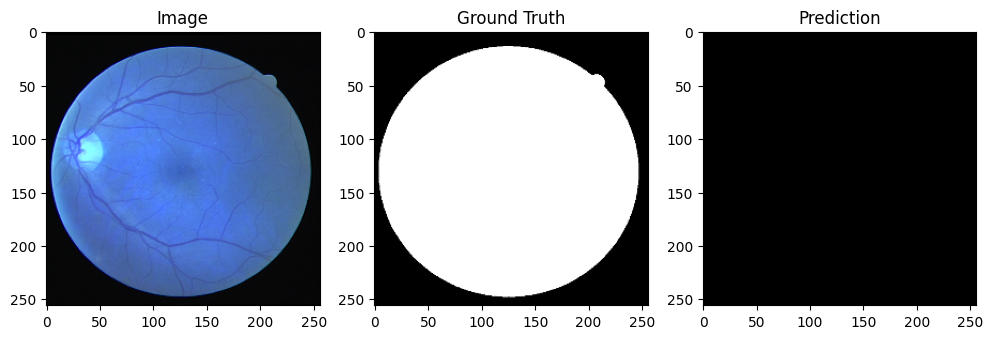

In [ ]:
import matplotlib.pyplot as plt

model.eval()

img, mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0,0].cpu()

pred_mask = (pred > 0.5).float()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Prediction")

plt.savefig("result.png")
plt.show()


In [ ]:
files.download("result.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.eval()

img, mask = next(iter(loader))

img = img.to(device)

with torch.no_grad():
    pred = model(img)

print("Min:", pred.min().item())
print("Max:", pred.max().item())
print("Mean:", pred.mean().item())


Min: 0.47867146134376526
Max: 0.48212507367134094
Mean: 0.4801127016544342


In [ ]:
criterion = nn.BCELoss()


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        smooth = 1e-8
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2. * intersection + smooth) / \
               (pred.sum() + target.sum() + smooth)

        return 1 - dice


dice_loss = DiceLoss()
bce_loss = nn.BCELoss()

def hybrid_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)


In [ ]:
criterion = hybrid_loss


In [ ]:
epochs = 20


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        smooth = 1e-8
        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2 * intersection + smooth) / \
               (pred.sum() + target.sum() + smooth)

        return 1 - dice


dice_loss = DiceLoss()
bce_loss = nn.BCELoss()

def hybrid_loss(pred, target):
    return bce_loss(pred, target) + dice_loss(pred, target)

criterion = hybrid_loss


In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for img, mask in loader:
        img = img.to(device)
        mask = mask.to(device)

        pred = model(img)
        loss = criterion(pred, mask)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/20, Loss: 6.1161
Epoch 2/20, Loss: 6.1462
Epoch 3/20, Loss: 6.1346
Epoch 4/20, Loss: 6.1314
Epoch 5/20, Loss: 6.1025
Epoch 6/20, Loss: 6.1211
Epoch 7/20, Loss: 6.1022
Epoch 8/20, Loss: 6.1245
Epoch 9/20, Loss: 6.1355
Epoch 10/20, Loss: 6.1154
Epoch 11/20, Loss: 6.1451
Epoch 12/20, Loss: 6.1225
Epoch 13/20, Loss: 6.1205
Epoch 14/20, Loss: 6.1155
Epoch 15/20, Loss: 6.1183
Epoch 16/20, Loss: 6.1354
Epoch 17/20, Loss: 6.1237
Epoch 18/20, Loss: 6.1209
Epoch 19/20, Loss: 6.1234
Epoch 20/20, Loss: 6.1489


In [55]:
model.eval()

img, mask = next(iter(loader))
img = img.to(device)

with torch.no_grad():
    pred = model(img)

print("Min:", pred.min().item())
print("Max:", pred.max().item())
print("Mean:", pred.mean().item())


Min: 0.01280844397842884
Max: 0.9024544954299927
Mean: 0.46874064207077026


In [56]:
model.eval()

p_total = 0
r_total = 0
i_total = 0
d_total = 0

with torch.no_grad():
    for img, mask in loader:
        img = img.to(device)
        mask = mask.to(device)

        pred = model(img)
        pred_mask = (pred > 0.5).float()

        for i in range(img.size(0)):
            p_total += precision_score(pred_mask[i], mask[i])
            r_total += recall_score(pred_mask[i], mask[i])
            i_total += iou_score(pred_mask[i], mask[i])
            d_total += dice_score(pred_mask[i], mask[i])

n = len(dataset)

print("Precision:", p_total/n)
print("Recall:", r_total/n)
print("IoU:", i_total/n)
print("Dice:", d_total/n)


Precision: 0.49389632791280746
Recall: 0.2304185949265957
IoU: 0.18845064975321293
Dice: 0.3126702107489109


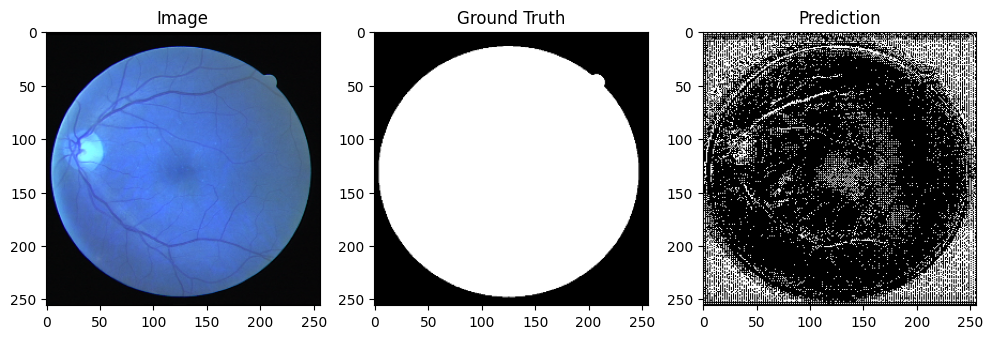

In [57]:
import matplotlib.pyplot as plt

model.eval()
img, mask = dataset[0]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0,0].cpu()

pred_mask = (pred > 0.5).float()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img.permute(1,2,0))
plt.title("Image")

plt.subplot(1,3,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask, cmap="gray")
plt.title("Prediction")

plt.show()


In [58]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
